# Objective: Convolutional Neural Network Classification Using Fashion MNIST
Here, I'm going to build an convolutional neural network classification model using PyTorch using fashion MNIST training data set.

## Import Libraries

In [1]:

import torch
import torch.nn as nn
import torch.utils
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

## Load Data
This covers how to download the data and load the data into the code.

In [2]:
# load train dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

In [3]:
# analyze train dataset
train_dataset.data.max()
train_dataset.data.shape
train_dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [4]:
# load test dataset
test_dataset = torchvision.datasets.FashionMNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=False
)

## Preprocess Data
This covers how to create batch using DataLoader.

In [5]:
# get number of classes
K = len(set(train_dataset.targets.numpy()))
print(f"The number of classes: {K}")

The number of classes: 10


In [6]:
# confirm whether the data is normalized or not
train_dataset.transform(train_dataset.data.numpy()).max()

tensor(1.)

In [7]:
# dataloader to automatically generate batches in the training loop with shuffling
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [8]:
# understand DataLoader better
tmp_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                         batch_size=1, 
                                         shuffle=True)
for x, y in tmp_loader:
    print(x)
    print(x.shape)
    print(y)
    print(y.shape)
    break

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

## Build Model
This covers how to build a convolutional neural network classification model using fashion MNIST dataset to train. Since the dataset is big enough, we can use GPU for faster process if available.

In [9]:
# define the model
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
            # grayscale -> in_channels=1
            # stride=2 -> no more pooling needed
            # default padding (k) is 0
            # default dialation (d) is 1
            # H_out = floor[(H_in + 2*p - d(k-1) - 1)/2 + 1] = 13
            # image will be 28X28 -> 13X13
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            # image size = 13X13 -> 6X6
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            # image size = 6X6 -> 2X2
            nn.ReLU()
        )
        # image size through conv layer: 28X28 -> 2X2
        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(128 * 2 * 2, 512),
            # input vector: 128 feature maps and each map's image is 2X2
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, K)
        )
        
    def forward(self, X):
        out = self.conv_layers(X)
        out = out.view(out.size(0), -1)
        # out.size(0) is the batch size to make -1 as 128 * 2 * 2
        out = self.dense_layers(out)
        return out

model = CNN(K)

In [10]:
# same model with different structure
# model = nn.Sequential(
#     nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
#     nn.ReLU(),
#     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
#     nn.ReLU(),
#     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
#     nn.ReLU(),
#     nn.Flatten(),
#     nn.Dropout(0.2),
#     nn.Linear(128 * 2 * 2, 512),
#     nn.ReLU(),
#     nn.Dropout(0.2),
#     nn.Linear(512, K)
# )

In [11]:
# activate gpu if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# send the model details to the device
model.to(device)

cuda:0


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [12]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

## Training
This covers how to train the convolutional neural network classification model with the input data that we processed.

In [13]:
# build a function for training using batch gradient descent
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    # losses will be stored to plot the results
    # storage for losses per each epoch
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for epoch in range(epochs):
        # train mode
        model.train()
        # details: https://pytorch.org/docs/stable/_modules/torch/nn/modules/module.html#Module.train
        # details: https://medium.com/jun94-devpblog/pytorch-6-model-train-vs-model-eval-no-grad-hyperparameter-tuning-3812c216a3bd
        t0 = datetime.now()     # set the first timestamp
        train_loss = []
        for inputs, targets in train_loader:
            # move data to the designated device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # zero the parameter gradients to make sure they are zero
            optimizer.zero_grad()
            
            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # backward and optimize
            loss.backward()
            optimizer.step()
            
            # save the loss
            train_loss.append(loss.item())
            
        ## get train loss per epoch as average loss of all the batches in that epoch
        train_loss = np.mean(train_loss)
        train_losses[epoch] = train_loss
        
        # test mode
        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)
        test_losses[epoch] = test_loss
        
        dt = datetime.now() - t0      # calculate time spent
        # print out the result
        print(f"Epoch {epoch+1}/{epochs}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Duration: {dt}")
        
    return train_losses, test_losses

In [14]:
# get the result
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=15
)

Epoch 1/15, Train loss: 0.6441, Test loss: 0.4567, Duration: 0:00:04.218331
Epoch 2/15, Train loss: 0.4184, Test loss: 0.3981, Duration: 0:00:04.017202
Epoch 3/15, Train loss: 0.3640, Test loss: 0.3519, Duration: 0:00:04.019933
Epoch 4/15, Train loss: 0.3242, Test loss: 0.3309, Duration: 0:00:04.019065
Epoch 5/15, Train loss: 0.2991, Test loss: 0.3108, Duration: 0:00:04.039396
Epoch 6/15, Train loss: 0.2773, Test loss: 0.2983, Duration: 0:00:04.023069
Epoch 7/15, Train loss: 0.2596, Test loss: 0.2880, Duration: 0:00:04.018308
Epoch 8/15, Train loss: 0.2434, Test loss: 0.2831, Duration: 0:00:04.022571
Epoch 9/15, Train loss: 0.2273, Test loss: 0.2735, Duration: 0:00:04.018290
Epoch 10/15, Train loss: 0.2126, Test loss: 0.3009, Duration: 0:00:04.018137
Epoch 11/15, Train loss: 0.2003, Test loss: 0.2842, Duration: 0:00:04.029977
Epoch 12/15, Train loss: 0.1898, Test loss: 0.2806, Duration: 0:00:04.048660
Epoch 13/15, Train loss: 0.1777, Test loss: 0.2775, Duration: 0:00:04.020874
Epoch 14

## Result
This shows the result of the convolutional neural network classification model by showing the loss evolution and calculating the accuracy of the model.

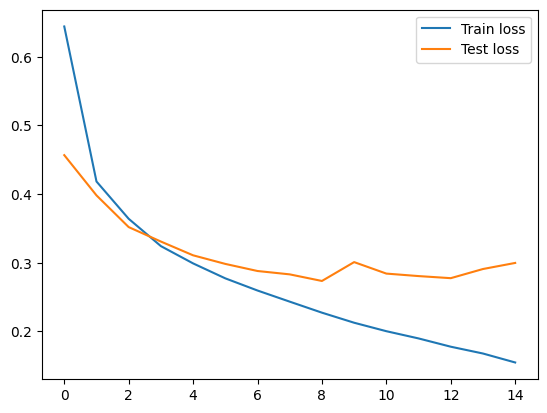

In [15]:
# plot the train loss and test loss per iteration
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.legend()
plt.show()

In [16]:
# calculate accuracy
# training accuracy
model.eval()    # we are not training anymore. we are just calculating the accuracy of training set inference
n_correct = 0.
n_total = 0.

for inputs, targets in train_loader:
    # move data to device
    inputs, targets = inputs.to(device), targets.to(device)
    
    # forward pass
    outputs = model(inputs)
    
    # get prediction by returning maximum value label
    _, predictions = torch.max(outputs, 1)
    
    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

# calculate training accuracy
train_acc = n_correct / n_total

# test accuracy
n_correct = 0.
n_total = 0.

for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

# calculate test accuracy
test_acc = n_correct / n_total

# print the result
print(f"Train accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}")

Train accuracy: 0.9584, Test accuracy: 0.9023


## Apendix: Confusion Matrix
This covers how to plot confusion matrix using the results that we got above.

In [17]:
# import libraries to plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

# function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix, without normalization
[[872   2  10  13   5   1  93   0   4   0]
 [  1 975   0  14   3   0   6   0   1   0]
 [ 23   1 804  10  70   0  87   0   5   0]
 [ 13   8  11 908  30   0  30   0   0   0]
 [  0   1  27  30 869   0  70   0   3   0]
 [  0   0   0   0   0 981   0  16   0   3]
 [112   0  33  19 102   1 725   0   8   0]
 [  0   0   0   0   0  14   0 978   0   8]
 [  4   0   5   5   5   3   2   5 971   0]
 [  0   0   0   0   0  10   1  49   0 940]]


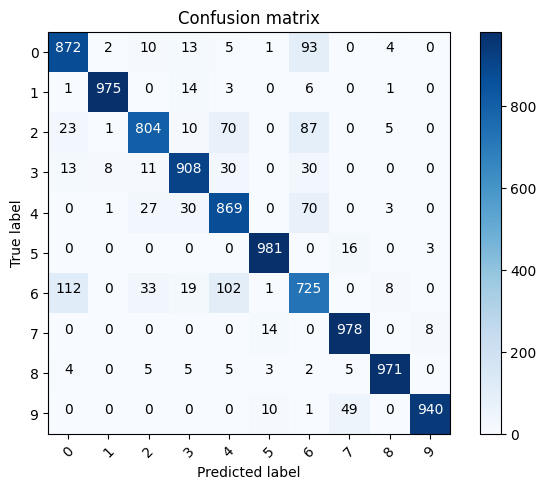

In [19]:
# get predictions in an array and plot the confusion matrix
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])

for inputs, targets in test_loader:
    # move data to device
    inputs = inputs.to(device)
    
    # forward pass
    outputs = model(inputs)
    
    # get predictions
    _, predictions = torch.max(outputs, 1)
    
    # update p_test
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))
    # need to bring the result back to cpu to process the plot
    
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))